<a href="https://colab.research.google.com/github/enieva67/Programas_sociales_tucuman/blob/master/Programas_sociales_tucuman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sentence_transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS

In [5]:
# Programas sociales
datos = pd.read_csv('/content/sample_data/programas.csv')
#datos['Parrafos']=datos['Traduccion'].apply(separar_texto_lineas)

In [6]:
categorias_es = [
    "Juventud y Adolescencia", "Salud Pública", "Nutrición", "Educación", "Empleo y Formación Laboral",
    "Inclusión Social", "Diversidad e Igualdad", "Cultura", "Deportes", "Turismo",
    "Ambiente y Sustentabilidad", "Seguridad Alimentaria", "Prevención de Adicciones", "Salud Mental",
    "Discapacidad", "Atención a Enfermedades Crónicas", "Prevención de Enfermedades", "Salud Animal",
    "Derechos Humanos", "Participación Comunitaria", "Apoyo Económico", "Desarrollo Social",
    "Vivienda y Habitabilidad", "Asistencia Legal", "Empoderamiento de Mujeres", "Control Ambiental",
    "Cuidado del Agua", "Protección contra el Cambio Climático", "Capacitación Técnica", "Promoción de la Salud",
    "Agricultura y Desarrollo Rural", "Innovación y Tecnología", "Gestión de Residuos", "Infraestructura",
    "Transporte", "Seguridad y Justicia", "Apoyo a Emprendedores", "Desarrollo Industrial",
    "Calidad e Inocuidad Alimentaria", "Inclusión Digital", "Desarrollo Urbano", "Fomento de la Economía Local",
    "Protección de la Biodiversidad", "Recursos Naturales", "Investigación y Desarrollo", "Asistencia Social",
    "Fortalecimiento Institucional", "Políticas de Género", "Protección y Bienestar Animal",
    "Promoción del Deporte y la Actividad Física"
]

categorias_en = [
    "Youth and Adolescence", "Public Health", "Nutrition", "Education", "Employment and Job Training",
    "Social Inclusion", "Diversity and Equality", "Culture", "Sports", "Tourism",
    "Environment and Sustainability", "Food Security", "Addiction Prevention", "Mental Health",
    "Disability", "Chronic Disease Management", "Disease Prevention", "Animal Health",
    "Human Rights", "Community Participation", "Economic Support", "Social Development",
    "Housing and Habitability", "Legal Assistance", "Women's Empowerment", "Environmental Control",
    "Water Care", "Climate Change Protection", "Technical Training", "Health Promotion",
    "Agriculture and Rural Development", "Innovation and Technology", "Waste Management", "Infrastructure",
    "Transport", "Safety and Justice", "Entrepreneurship Support", "Industrial Development",
    "Food Quality and Safety", "Digital Inclusion", "Urban Development", "Local Economy Promotion",
    "Biodiversity Protection", "Natural Resources", "Research and Development", "Social Assistance",
    "Institutional Strengthening", "Gender Policies", "Animal Protection and Welfare",
    "Promotion of Sports and Physical Activity"
]

categ=[str.lower(c)for c in categorias_en]

In [7]:
#Traductor del español al ingles
translator_es_to_en = pipeline("translation_es_to_en", model="Helsinki-NLP/opus-mt-es-en")

#Clasificador
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

# Load https://huggingface.co/sentence-transformers/all-mpnet-base-v2
model = SentenceTransformer("all-mpnet-base-v2")

#Funcion para traducir texto
def translate_es_to_en(text):
    translation = translator_es_to_en(text)
    return translation[0]['translation_text']

#Funcion para separar parrafos de un texto largo
def separar_texto_lineas(texto,sep='\n\n'):
    return str.split(texto,sep=sep)

#Funcion para agregar variables binarias a un dataframe segun el programa coincida con la categoria
def etiquetas(texto,categoria):
    for parrafo in texto:
        if len(parrafo)>0:
            cla=classifier(str.lower(parrafo),
                       candidate_labels=[str.lower(categoria)],)
            if float(cla['scores'][0])>0.9:
                print(cla['scores'][0])
                return 1

    return 0

#Funcion para calcular similaridades
def similaridades(pal='turismo',categ=categ,n=50):
    palabra1=str.lower(translate_es_to_en(pal))
    #palabra2=translate_es_to_en(pal)
    embeddings = model.encode(categ)
    embeddings_pal = model.encode([palabra1])
    similarities = model.similarity(embeddings, embeddings_pal)
    sim=similarities.reshape(n,)
    dfsim = {'Categoria':categorias_es , 'Sim': sim}
    dfsim=pd.DataFrame(dfsim).sort_values(by='Sim',ascending=False)
    df_max_pro=pd.DataFrame(datos.loc[datos[categorias_es[sim.argmax()]]==1,['Programas','Descripcion']]).reset_index(drop=True)
    return [df_max_pro,dfsim]

#Funcion para calcular la matriz de distancias y similaridades
def matriz_distancias_similaridades(datos):
    binary_matrix = datos.values

    # Calcular la matriz de distancia (1 - Jaccard Similarity)
    distances = pdist(binary_matrix.T, metric='jaccard')

    # Convertir las distancias a una matriz cuadrada
    distance_matrix = squareform(distances)
    return distance_matrix
    # Paso 2: Calcular las coordenadas principales usando PCoA (MDS con metric=False)
    #mds = MDS(n_components=2, dissimilarity='precomputed', metric=False)

    # Ajustar MDS a la matriz de distancia
    #principal_coordinates = mds.fit_transform(distance_matrix)

    # Crear un DataFrame con las coordenadas principales
    #pcoa_df = pd.DataFrame(data=principal_coordinates, columns=['PCo1', 'PCo2'], index=df.columns)

def realizar_suma_ponderada(datos,pesos,seleccionadas):
    df = datos

    # Lista de columnas a sumar ponderadamente
    columnas_a_sumar = seleccionadas

    # Lista de pesos correspondientes a cada columna
    pesos = pesos

    # Verificar que la longitud de las listas coincida
    if len(columnas_a_sumar) != len(pesos):
        raise ValueError("La longitud de columnas_a_sumar y pesos debe ser la misma.")

    # Crear una nueva columna con la suma ponderada de las columnas especificadas
    df['suma_ponderada'] = sum(df[col] * peso for col, peso in zip(columnas_a_sumar, pesos))

    # Mostrar el DataFrame resultante
    return df.sort_values(by='suma_ponderada',ascending=False).loc[:,['Programas','Descripcion','suma_ponderada']]

#Funcion para pbtener programas similares
def obtener_programas_similares(similarity_matrix, programa, top_n=10):
    # Verificar si el programa existe en la matriz
    if programa not in similarity_matrix.columns:
        raise ValueError(f"El programa '{programa}' no se encuentra en la matriz de similitud.")

    # Obtener la fila correspondiente al programa
    similaridades = similarity_matrix[programa]

    # Ordenar las similaridades en orden descendente y obtener los índices de los programas más similares
    # Excluir el propio programa usando 'iloc[1:top_n+1]' en lugar de 'iloc[:top_n]'
    programas_similares = similaridades.sort_values(ascending=False).iloc[1:top_n+1]

    return pd.DataFrame(programas_similares)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
matriz=pd.read_csv('/content/sample_data/matriz_de_similaridad_con_nombres.csv',index_col=0)

In [10]:
datosim=similaridades('turismo')
datosim[0].head()

,Programas,Descripcion
0,Turismo Educativo,"El programa de Turismo Educativo, bajo la coor..."
1,Programa Despertando Vocaciones,"El Programa Despertando Vocaciones, gestionado..."
2,Programa Cadillal Imperdible,"El Programa Cadillal Imperdible, bajo la direc..."
3,Programa de Fortalecimiento del Producto Turis...,El Programa de Fortalecimiento del Producto Tu...
4,Programa Tucumán Capacita,"El Programa Tucumán Capacita, bajo la direcció..."


In [11]:
datosim[1].head()

,Categoria,Sim
9,Turismo,1.000000
3,Educación,0.518202
7,Cultura,0.508851
33,Infraestructura,0.496606
1,Salud Pública,0.487914


In [12]:
Cat=datosim[1][datosim[1]['Sim']>0.5]
seleccionadas=list(Cat['Categoria'])
pesos=list(Cat['Sim'])

In [13]:
programa=datosim[0].Programas[2]
programa

'Programa Cadillal Imperdible'

In [15]:
#programa=datos.Programas[5]
prosim=obtener_programas_similares(matriz,programa)
#prosim
prosim.reset_index(names='Programas',inplace=True)
pd.merge(prosim,datos,on='Programas').iloc[:,:2]
#datos[datos.Programas.isin(prosim.index)].iloc[:,:2]

,Programas,Programa Cadillal Imperdible
0,Programa de Desarrollo y Fortalecimiento del P...,0.625000
1,Programa de Sensibilización E Información Turí...,0.437500
2,Programa Promoción del Trabajo Arraigo y Abast...,0.428571
3,Programa de Desarrollo y Fortalecimiento del T...,0.400000
4,Programa de Turismo Arqueológico,0.384615
5,Programa Diversificación y Sustentabilidad de ...,0.368421
6,Programa Tucumán Capacita,0.352941
7,Programa de Turismo Termal,0.333333
8,Educación Sin Paredes,0.333333
9,Programa la Escuela y el Turismo,0.312500


In [17]:
realizar_suma_ponderada(datos,pesos,seleccionadas).head()

,Programas,Descripcion,suma_ponderada
166,Programa Para el Fortalecimiento Gastronómico,El Programa para el Fortalecimiento Gastronómi...,2.027052
167,Programa la Escuela y el Turismo,"El Programa ""La Escuela y el Turismo"", impulsa...",2.027052
169,Programa de Sensibilización E Información Turí...,El Programa de Sensibilización e Información T...,2.027052
136,Programa Despertando Vocaciones,"El Programa Despertando Vocaciones, gestionado...",1.518202
129,Turismo Educativo,"El programa de Turismo Educativo, bajo la coor...",1.518202


In [18]:
# Supongamos que df es tu dataframe de pandas con variables binarias
df = datos.iloc[:,5:-1]

# Paso 1: Calcular la matriz de distancia usando el coeficiente de Jaccard
# Convertir las columnas a matrices booleanas
binary_matrix = df.values

# Calcular la matriz de distancia (1 - Jaccard Similarity)
distances = pdist(binary_matrix, metric='jaccard')

# Convertir las distancias a una matriz cuadrada
distance_matrix = squareform(distances)

# Paso 2: Calcular las coordenadas principales usando PCoA (MDS con metric=False)
mds = MDS(n_components=2, dissimilarity='precomputed', metric=False)

# Ajustar MDS a la matriz de distancia
principal_coordinates = mds.fit_transform(distance_matrix)

# Crear un DataFrame con las coordenadas principales
pcoa_df = pd.DataFrame(data=principal_coordinates, columns=['PCo1', 'PCo2'], index=datos.Programas)

#print("Matriz de distancia (Jaccard):")
#print(distance_matrix)
#print("\nCoordenadas principales (PCoA):")
(pcoa_df)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


,PCo1,PCo2
Programas,,
Boxeo en Tu Barrio,-0.132338,0.153176
Programa Organizar,0.213906,0.418698
Programa de Apoyo Urgente (Pau),-0.140277,-0.417465
Programa Provincial Iguales y Diversos,-0.078856,0.214523
Potenciar Acompañamiento,0.358852,0.240369
...,...,...
Programa Construyendo Tu Identidad,0.103384,0.362972
Programa Tucumanitos,-0.674305,-0.548534
Programa Consumo Cuidado,0.120203,-0.100997


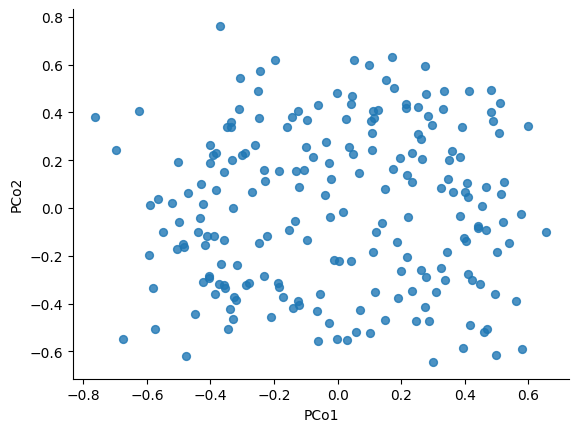

In [21]:
# @title PCo1 vs PCo2

from matplotlib import pyplot as plt
pcoa_df.plot(kind='scatter', x='PCo1', y='PCo2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [20]:
datos.head()

,Programas,Descripcion,Traduccion,Programas_en _ingles,Parrafos,Educación,Empleo y Formación Laboral,Inclusión Social,Diversidad e Igualdad,Cultura,...,Investigación y Desarrollo,Asistencia Social,Fortalecimiento Institucional,Políticas de Género,Protección y Bienestar Animal,Promoción del Deporte y la Actividad Física,Juventud y Adolescencia,Salud Pública,Nutrición,suma_ponderada
0,Boxeo en Tu Barrio,Boxeo en Tu Barrio es un programa del Minister...,Boxing in Your Neighborhood is a program by th...,Boxing in Tu Barrio,['Boxing in Your Neighborhood is a program by ...,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0.0
1,Programa Organizar,Programa Organizar es gestionado por la Secret...,"The ""Organize Program"" is managed by the Secre...",Organizing Programme,"['The ""Organize Program"" is managed by the Sec...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,Programa de Apoyo Urgente (Pau),Programa de Apoyo Urgente (PAU) es gestionado ...,The Urgent Support Program (PAU) is managed by...,Emergency Support Programme (Pau),['The Urgent Support Program (PAU) is managed ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,Programa Provincial Iguales y Diversos,"El Programa Provincial ""Iguales y Diversos"" es...",The Provincial Program Equal and Diverse is ma...,Provincial Equal and Miscellaneous Programme,"[""The Provincial Program Equal and Diverse is ...",0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0.0
4,Potenciar Acompañamiento,"El Programa ""Potenciar Acompañamiento"" es gest...",The Empowerment Support Program is managed by ...,Enhancing Accompaniment,['The Empowerment Support Program is managed b...,0,1,1,0,0,...,0,0,0,0,0,0,1,1,0,0.0
